In [5]:
!pip3 install fuzzywuzzy

Defaulting to user installation because normal site-packages is not writeable
  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl (18 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [8]:
#!wget https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_BRA_shp.zip
#!unzip gadm36_BRA_shp.zip -d shp

zsh:1: command not found: wget


In [17]:
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install geopandas
#!pip3 install matplotlib
#!pip3 install openpyxl

In [13]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import style
from fuzzywuzzy import fuzz

/Users/tmedeirosb/Library/Python/3.9/lib/python/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [18]:
df = pd.read_excel('relatorio_inscricoes_geral_Sistema Funcern_anonimo_unificado.xlsx')

df_rn = df[df['UF'] == 'RN'].copy()
df_rn['Municipio'] = df_rn['Municipio'].str.title().str.strip()

In [19]:
uf_br2 = gpd.read_file('shp/gadm36_BRA_2.shp')
uf_rn = uf_br2[uf_br2['NAME_1'] == 'Rio Grande do Norte']
rn_cities = uf_rn['NAME_2'].unique().tolist()

In [20]:
def clean_city(city, cities_list):
    max_ratio = 0
    max_city = ''
    for city_item in cities_list:
        ratio = fuzz.ratio(city, city_item)
        #print(city)
        #print(city_item)
        #print(ratio)
        #break
        #if ratio > 85:
        if ratio > max_ratio:
            max_ratio = ratio
            max_city = city_item
        if max_ratio > 90:
            return max_city
    return max_city

df_rn['Cidade'] = df_rn['Municipio'].apply(lambda x: clean_city(x, rn_cities))

<Axes: xlabel='Cidade'>

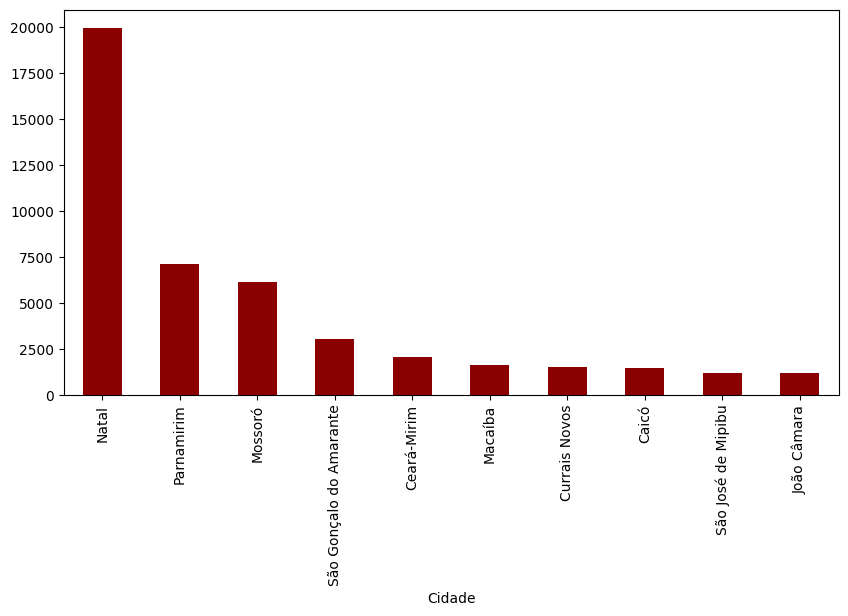

In [48]:
df_rn['Cidade'].value_counts()[:10].plot(kind='bar', figsize=(10,5), color='darkred')

In [49]:
# Porcentagem de linhas descartadas
len(df_rn[df_rn['Cidade'] == ''])/len(df_rn)

0.0001980176235684976

In [63]:
def count_population(df_rn, uf_rn):
    df_rn_cities = df_rn['Cidade'].value_counts().reset_index()
    df_count = uf_rn[['NAME_2', 'geometry']].merge(df_rn_cities, left_on='NAME_2', right_on='Cidade', how='inner')
    df_count.rename(columns={'count': 'population'}, inplace=True)
    return df_count

<Axes: >

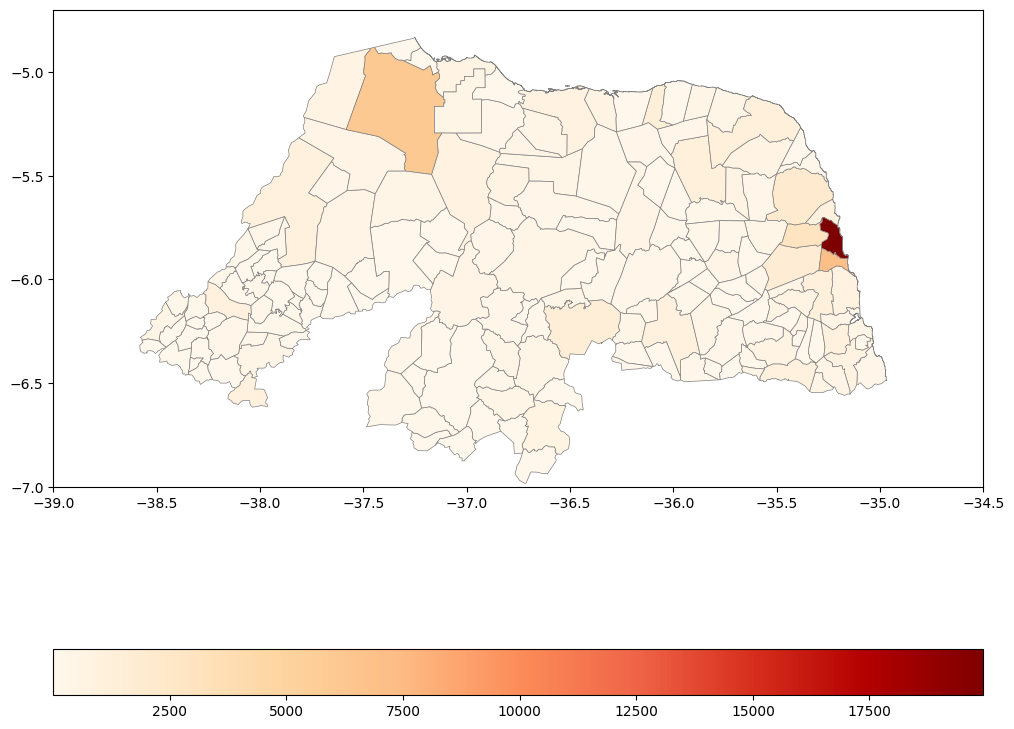

In [64]:
df_count = count_population(df_rn, uf_rn)

f, ax = plt.subplots(1, figsize=(12,14))

ax.set_xlim([-39.0, -34.5])
ax.set_ylim([-7.0, -4.7])

ax.set_axis_on()
df_count.plot(ax=ax, column='population', cmap='OrRd', edgecolor='grey', linewidth=0.5, legend=True, legend_kwds={'orientation': "horizontal"})

In [61]:
df_rn.to_csv('relatorio_inscricoes_geral_Sistema_tratado.csv')

/var/folders/fh/g5fgxqq513n014czxdxy7sfc0000gn/T/ipykernel_35661/476161168.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points.geometry = points['geometry'].centroid


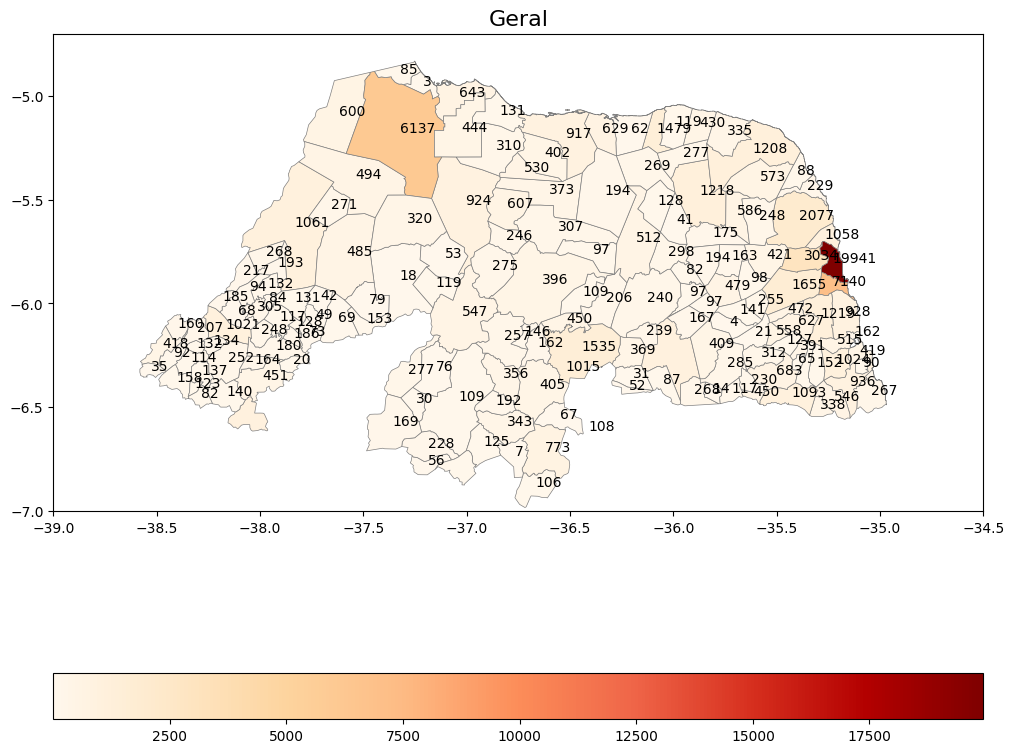

In [65]:
#df_rn_cities = df_rn['Cidade'].value_counts().reset_index()
#df_rn_cities.rename(columns={'Cidade': 'NAME_2', 'count': 'population'}, inplace=True)
#df_count = uf_rn.merge(df_rn_cities, on='NAME_2', how='outer')
df_count['population'].fillna(0, inplace=True)

f, ax = plt.subplots(1, figsize=(12,14))
#ax.set_title(unidade, fontsize=16)
ax.set_title("Geral", fontsize=16)
ax.set_xlim([-39.0, -34.5])
ax.set_ylim([-7.0, -4.7])
ax.set_axis_on()
df_count.plot(ax=ax, column='population', cmap='OrRd', edgecolor='grey', linewidth=0.5, legend=True, legend_kwds={'orientation': "horizontal"})

points = df_count.copy()
points.geometry = points['geometry'].centroid
points.head()

for x, y, label in zip(points.geometry.x, points.geometry.y, points.population):
    ax.annotate(int(label), xy=(x, y), xytext=(0, 0), textcoords="offset points",color='black')

In [45]:
def plot_map(df_rn, uf_rn, campus, concurso):
    df_count = count_population(df_rn, uf_rn)
    df_count['population'].fillna(0, inplace=True)

    f, ax = plt.subplots(1, figsize=(12,14))
    ax.set_xlim([-39.0, -34.5])
    ax.set_ylim([-7.0, -4.7])
    plt.title(f"Concurso x Campus {concurso, campus}")
    ax.set_axis_on()
    df_count.plot(ax=ax, column='population', cmap='OrRd', edgecolor='grey', linewidth=0.5, legend=True, legend_kwds={'orientation': "horizontal"})

    points = df_count.copy()
    points.geometry = points['geometry'].centroid
    #points.head()

    for x, y, label in zip(points.geometry.x, points.geometry.y, points.population):
        ax.annotate(int(label), xy=(x, y), xytext=(0, 0), textcoords="offset points",color='black')

    f, ax = plt.subplots(1, figsize=(12,14))
    #ax.set_xlim([-39.0, -34.5])
    #ax.set_ylim([-7.0, -4.7])
    plt.title(f"Bar Concurso x Campus {concurso, campus}")
    #ax.set_axis_on()
    df_sorted = df_count.sort_values(by='population', ascending=False)
    top_30 = df_sorted.iloc[:30]
    top_30.plot(ax=ax, kind="bar", x='NAME_2', y='population', legend=False)

    #df_count.plot(ax=ax, kind="bar", column='population', x='NAME_2', legend=False)


    #ax.set_xticks([])
    ax.set_xlabel('')

    # Adicionando os valores acima das barras
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.text(x+width/2,
                y+height+0.02*max(df_count['population']),  # Ajustando a posição do número para que fique acima da barra
                '{:.0f}'.format(height),
            horizontalalignment='center')

/var/folders/fh/g5fgxqq513n014czxdxy7sfc0000gn/T/ipykernel_35661/2955222118.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points.geometry = points['geometry'].centroid


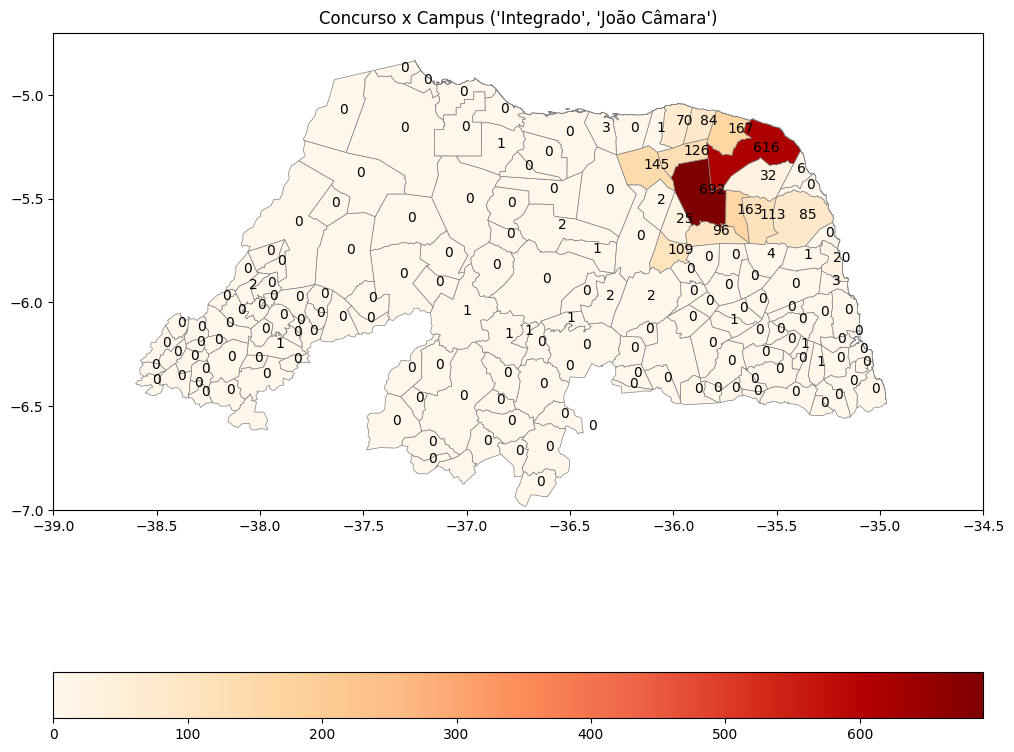

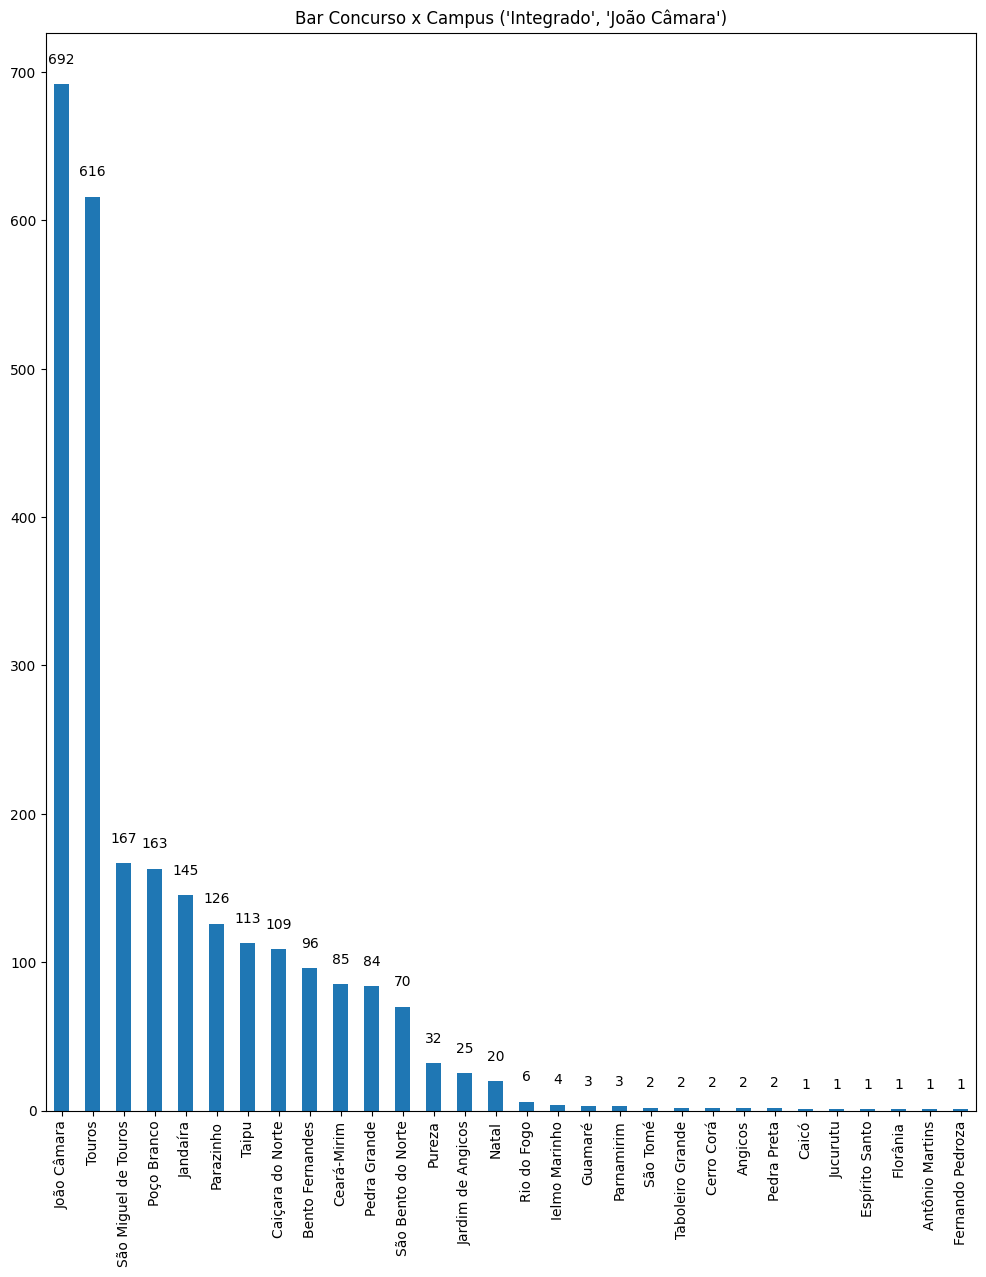

In [67]:
# Criando gráficos de barras para cada campus
unidades = df_rn["Unidade"].unique()
editais = df_rn["Concurso"].unique()

editais_selecionados = {
    'Integrado':
    ['IFRN Edital 29/2019 - Cursos Técnicos Integrados 2020',
    'IFRN Edital 41/2021 - Cursos Técnicos Integrados 2022',
    'IFRN Edital 40/2022 - Cursos Técnicos Integrados 2023'],
    'Subsequente':
    ['IFRN Edital 30/2019 - Cursos Técnicos Subsequentes 2020.1',
    'IFRN Edital 12/2020 - Cursos Técnicos Subsequentes 2020.2',
    'IFRN Edital 28/2021 - Cursos Técnicos Subsequentes 2021.2',
    'IFRN Edital 48/2021 - Cursos Técnicos Subsequentes 2022.1',
    'IFRN Edital 20/2022 - Subsequente 2022.2',
    'IFRN Edital 48/2022 - Subsequente 2023.1',
    'IFRN Edital 24/2023 - Técnico Subsequente 2023.2']
}
for concurso in editais_selecionados:
    for campus in unidades:
        data_for_campus = df_rn[(df_rn["Unidade"] == campus) & (df_rn["Concurso"].isin(editais_selecionados[concurso]))]
        if not data_for_campus.empty and data_for_campus.shape[0] > 1:
            plot_map(data_for_campus, uf_rn, campus, concurso)
        #break
    #break